In [1]:
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import optuna

# Datasets

In [2]:
HDData=pd.read_csv('HD selected 10 features.csv')
HDData.head()

,age,sex,cp,chol,restecg,thalach,exang,oldpeak,ca,thal,label
0,63,1,1,233,2,150,0,2.3,0,6,0
1,67,1,4,286,2,108,1,1.5,3,3,1
2,67,1,4,229,2,129,1,2.6,2,7,1
3,37,1,3,250,0,187,0,3.5,0,3,0
4,41,0,2,204,2,172,0,1.4,0,3,0


<AxesSubplot:xlabel='label', ylabel='count'>

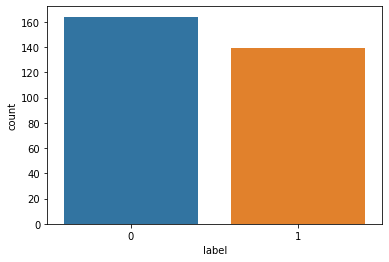

In [3]:
sns.countplot(x='label',data=HDData)

# Build the model

In [4]:
HDData.shape

(303, 11)

In [5]:
HDData01=HDData.copy()

In [6]:
X1=HDData01.drop(labels=['label'],axis=1)

y1=HDData01['label'].values
y1 = LabelEncoder().fit_transform(y1)

In [7]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

### Artificial Neural Network

Load data

In [8]:
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)
print("X_train.shape :",X1_train.shape)
print("X_test.shape :",X1_test.shape)
# print(X_train.head())


X_train.shape : (242, 10)
X_test.shape : (61, 10)


Define the dataset

In [9]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Define the Optuna  model

In [10]:

# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 10
# looping to determine the number of layers and nodes in each layer     
    for i in range(n_layers):
#         the number of nodes in each layer.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
#         p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#         layers.append(nn.Dropout(p))
        
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 10))
#     layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in test_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model, trial)

    return accuracy
  
EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)



[I 2022-09-09 15:35:05,114] A new study created in memory with name: no-name-f4734063-b33d-47f3-a2d0-0a8c0d9e4b46
C:\Users\COOLER~1\AppData\Local\Temp/ipykernel_16184/3318135143.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2022-09-09 15:35:05,261] Trial 0 finished with value: 0.7213114754098361 and parameters: {'learning_rate': 0.0006360539349309912, 'optimizer': 'Adam', 'n_layers': 1, 'n_units_l0': 10}. Best is trial 0 with value: 0.7213114754098361.
[I 2022-09-09 15:35:05,381] Trial 1 finished with value: 0.8524590163934426 and parameters: {'learning_rate': 0.004508065858019759, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 14}. Best is trial 1 with value: 0.8524590163934426.
[I 2022-09-09 15:35:05,521] Trial 2 finished with

In [11]:
#the best result
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.002118026787621538
optimizer: Adam
n_layers: 2
n_units_l0: 104
n_units_l1: 66


In [12]:
# learning_rate: 0.0016759066603823113
# optimizer: RMSprop
# n_layers: 1
# n_units_l0: 65




In [13]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()      
       
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        return out


In [14]:
epochs =30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim=65
output_dim = len(set(y1))

In [15]:
model = ANNModel(input_dim, hidden_dim,output_dim)


learning_rate = 0.0016
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [17]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) #from double to float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #backword propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # accumulate the loss of each step 
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) #from double to float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:0.3046 accuracy:0.8516 precision:0.8516 recall:0.8516 f1:0.8516
[sklearn_metrics] Epoch:0 loss:0.5737 accuracy:0.8719 precision:0.8719 recall:0.8719 f1:0.8719
[sklearn_metrics] Epoch:1 loss:0.2794 accuracy:0.8906 precision:0.8906 recall:0.8906 f1:0.8906
[sklearn_metrics] Epoch:1 loss:0.5674 accuracy:0.8760 precision:0.8760 recall:0.8760 f1:0.8760
[sklearn_metrics] Epoch:2 loss:0.2704 accuracy:0.8750 precision:0.8750 recall:0.8750 f1:0.8750
[sklearn_metrics] Epoch:2 loss:0.5660 accuracy:0.8760 precision:0.8760 recall:0.8760 f1:0.8760
[sklearn_metrics] Epoch:3 loss:0.2597 accuracy:0.8984 precision:0.8984 recall:0.8984 f1:0.8984
[sklearn_metrics] Epoch:3 loss:0.5622 accuracy:0.8802 precision:0.8802 recall:0.8802 f1:0.8802
[sklearn_metrics] Epoch:4 loss:0.2376 accuracy:0.8984 precision:0.8984 recall:0.8984 f1:0.8984
[sklearn_metrics] Epoch:4 loss:0.5628 accuracy:0.8802 precision:0.8802 recall:0.8802 f1:0.8802
[sklearn_metrics] Epoch:5 loss:0.2866 accuracy:0.8

In [18]:
training_time_ann

'0.2896'